In [1]:
%load_ext autoreload
%autoreload 2

import sys, os
sys.path.insert(0, '..')
from lib import models, graph, coarsening, utils

import tensorflow as tf
import matplotlib.pyplot as plt
import scipy.sparse
import numpy as np
import time

%matplotlib inline

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/gensim/utils.py:1015: UserWarning: Pattern library is not installed, lemmatization won't be available.
  warnings.warn("Pattern library is not installed, lemmatization won't be available.")


In [2]:
flags = tf.app.flags
FLAGS = flags.FLAGS

# Graphs.
flags.DEFINE_integer('number_edges', 16, 'Graph: minimum number of edges per vertex.')
flags.DEFINE_string('metric', 'cosine', 'Graph: similarity measure (between features).')
# TODO: change cgcnn for combinatorial Laplacians.
flags.DEFINE_bool('normalized_laplacian', True, 'Graph Laplacian: normalized.')
flags.DEFINE_integer('coarsening_levels', 0, 'Number of coarsened graphs.')

flags.DEFINE_string('dir_data', os.path.join('..', 'data', '20news'), 'Directory to store data.')
flags.DEFINE_integer('val_size', 400, 'Size of the validation set.')

# Data

In [27]:
# Fetch dataset. Scikit-learn already performs some cleaning.
remove = ('headers','footers','quotes')  # (), ('headers') or ('headers','footers','quotes')
#train = utils.Text20News(data_home=FLAGS.dir_data, subset='train', remove=remove)

train = utils.TextBeers()


# Pre-processing: transform everything to a-z and whitespace.
print(train.show_document(1)[:400])
train.clean_text(num='substitute')

# Analyzing / tokenizing: transform documents to bags-of-words.
#stop_words = set(sklearn.feature_extraction.text.ENGLISH_STOP_WORDS)
# Or stop words from NLTK.
# Add e.g. don, ve.
train.vectorize(stop_words='english')
print(train.show_document(1)[:400])

10 10
N = 40000 documents, C = 10 classes
document 1: label 6 --> 6, 61 words
Dark red color, light beige foam, average.	In the smell malt and caramel, not really light.	Again malt and caramel in the taste, not bad in the end.	Maybe a note of honey in teh back, and a light fruitiness.	Average body.	In the aftertaste a light bitterness, with the malt and red fruit.	Nothing exceptional, but not bad, drinkable beer.
document 1: label 6 --> 6, 61 words
  1.00 "aftertaste" (630)
  2.00 "average" (2338)
  2.00 "bad" (2515)
  1.00 "beer" (3079)
  1.00 "beige" (3231)
  1.00 "bitterness" (3714)
  1.00 "body" (4109)
  2.00 "caramel" (5683)
  1.00 "color" (7472)
  1.00 "dark" (9265)
  1.00 "drinkable" (11283)
  1.00 "end" (12163)
  1.00 "exceptional" (12816)
  1.00 "foam" (14245)
  1.00 "fruit" (14795)
  1.00 "fruitiness" (14810)
  1.00 "honey" (17295)
  4.00 "light" (20705)
  3.00 "malt" (21651)
  1.00 "maybe" (22077)
  1.00 "note" (24278)
  1.00 "really" (28787)
  2.00 "red" (28988)
  1.00 "sme

In [4]:
# Fetch dataset. Scikit-learn already performs some cleaning.
remove = ('headers','footers','quotes')  # (), ('headers') or ('headers','footers','quotes')
train2 = utils.Text20News(data_home=FLAGS.dir_data, subset='train', remove=remove)



# Pre-processing: transform everything to a-z and whitespace.
print(train2.show_document(1)[:400])
train2.clean_text(num='substitute')

# Analyzing / tokenizing: transform documents to bags-of-words.
#stop_words = set(sklearn.feature_extraction.text.ENGLISH_STOP_WORDS)
# Or stop words from NLTK.
# Add e.g. don, ve.
train2.vectorize(stop_words='english')
print(train2.show_document(1)[:400])

N = 11314 documents, C = 20 classes
document 1: label 4 --> comp.sys.mac.hardware, 90 words
A fair number of brave souls who upgraded their SI clock oscillator have
shared their experiences for this poll. Please send a brief message detailing
your experiences with the procedure. Top speed attained, CPU rated speed,
add on cards and adapters, heat sinks, hour of usage per day, floppy disk
functionality with 800 and 1.4 m floppies are especially requested.

I will be summarizing in the nex
document 1: label 4 --> comp.sys.mac.hardware, 92 words
  1.00 "adapters" (669)
  2.00 "add" (684)
  1.00 "answered" (2523)
  1.00 "attained" (3941)
  1.00 "base" (5026)
  1.00 "brave" (7179)
  1.00 "brief" (7318)
  1.00 "cards" (8579)
  2.00 "clock" (10473)
  1.00 "cpu" (12728)
  1.00 "day" (14053)
  1.00 "days" (14068)
  1.00 "detailing" (15215)
  1.00 "disk" (16087)
  1.00 "especially" (19550)
  2.00 "experiences" (20279)
  1.00 "fair" (20691)
  1.00 "floppies" (22013)
  1.00 "floppy" (22014)
  1.00

N = 40000 documents, M = 40486 words, sparsity=0.1425%
      3 documents in class  0 (0)
      0 documents in class  1 (1)
    185 documents in class  2 (2)
    271 documents in class  3 (3)
    867 documents in class  4 (4)
   1239 documents in class  5 (5)
   3505 documents in class  6 (6)
   6727 documents in class  7 (7)
  14611 documents in class  8 (8)
   9605 documents in class  9 (9)
N = 39978 documents, M = 40486 words, sparsity=0.1426%
shortest: 0, longest: 914 words
N = 39978 documents, M = 40486 words, sparsity=0.1426%


/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/matplotlib/axes/_base.py:3179: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=1.0, top=1.0
  'bottom=%s, top=%s') % (bottom, top))


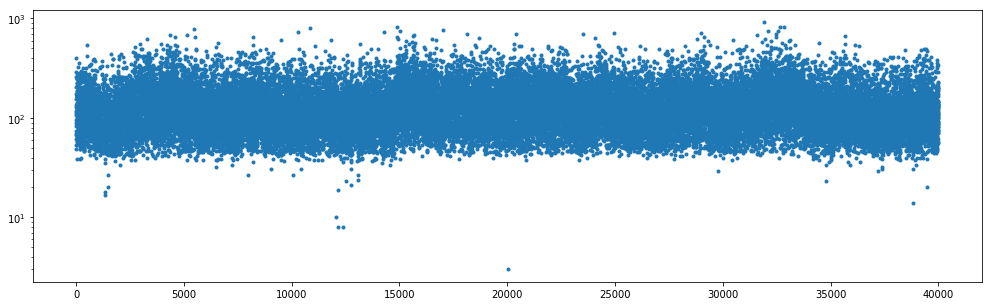

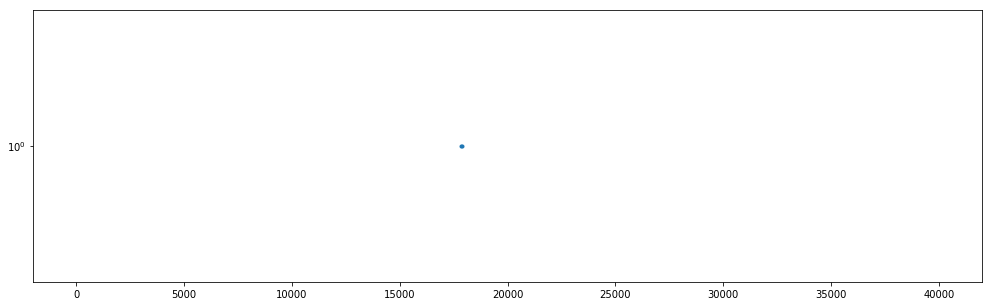

In [28]:
# Remove short documents.
train.data_info(True)
wc = train.remove_short_documents(nwords=20, vocab='full')
train.data_info()
print('shortest: {}, longest: {} words'.format(wc.min(), wc.max()))
plt.figure(figsize=(17,5))
plt.semilogy(wc, '.');

# Remove encoded images.
def remove_encoded_images(dataset, freq=1e3):
    widx = train.vocab.index('ax')
    wc = train.data[:,widx].toarray().squeeze()
    idx = np.argwhere(wc < freq).squeeze()
    dataset.keep_documents(idx)
    return wc
wc = remove_encoded_images(train)
train.data_info()
plt.figure(figsize=(17,5))
plt.semilogy(wc, '.');

N = 10181 documents, M = 72607 words, sparsity=0.0941%
    429 documents in class  0 (alt.atheism)
    523 documents in class  1 (comp.graphics)
    525 documents in class  2 (comp.os.ms-windows.misc)
    553 documents in class  3 (comp.sys.ibm.pc.hardware)
    513 documents in class  4 (comp.sys.mac.hardware)
    552 documents in class  5 (comp.windows.x)
    531 documents in class  6 (misc.forsale)
    515 documents in class  7 (rec.autos)
    501 documents in class  8 (rec.motorcycles)
    498 documents in class  9 (rec.sport.baseball)
    537 documents in class 10 (rec.sport.hockey)
    550 documents in class 11 (sci.crypt)
    536 documents in class 12 (sci.electronics)
    554 documents in class 13 (sci.med)
    539 documents in class 14 (sci.space)
    564 documents in class 15 (soc.religion.christian)
    504 documents in class 16 (talk.politics.guns)
    510 documents in class 17 (talk.politics.mideast)
    423 documents in class 18 (talk.politics.misc)
    324 documents in cl

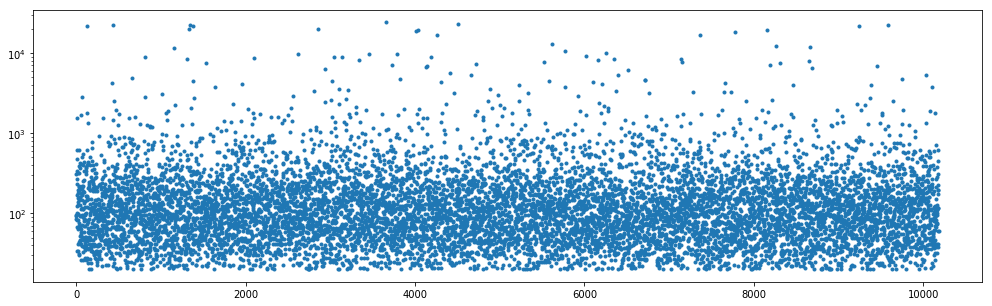

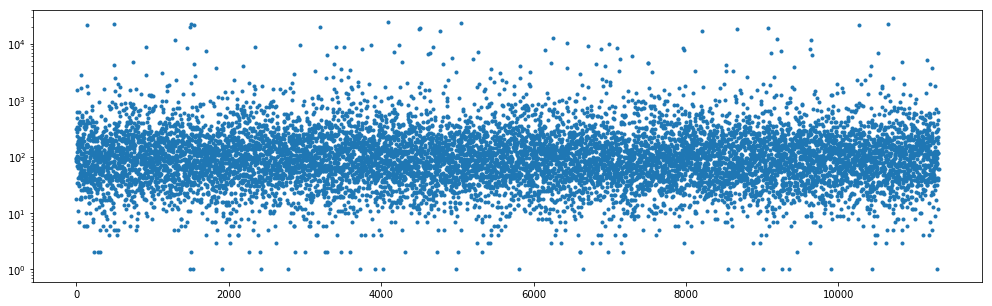

In [7]:
# Remove short documents.
train2.data_info(True)
wc2 = train2.remove_short_documents(nwords=20, vocab='full')
train2.data_info()
print('shortest: {}, longest: {} words'.format(wc2.min(), wc2.max()))
plt.figure(figsize=(17,5))
plt.semilogy(wc2, '.');

# Remove encoded images.
def remove_encoded_images(dataset, freq=1e3):
    widx = train2.vocab.index('ax')
    wc2 = train2.data[:,widx].toarray().squeeze()
    idx = np.argwhere(wc2 < freq).squeeze()
    dataset.keep_documents(idx)
    return wc2
wc2 = remove_encoded_images(train2)
train2.data_info()
plt.figure(figsize=(17,5))
plt.semilogy(wc, '.');

In [29]:
# Word embedding
if True:
    train.embed()
else:
    train.embed(os.path.join('..', 'data', 'word2vec', 'GoogleNews-vectors-negative300.bin'))
train.data_info()
# Further feature selection. (TODO)

27864 words not found in corpus
N = 39978 documents, M = 12622 words, sparsity=0.4489%


In [18]:
# Word embedding
if True:
    train2.embed()
else:
    train2.embed(os.path.join('..', 'data', 'word2vec', 'GoogleNews-vectors-negative300.bin'))
train2.data_info()
# Further feature selection. (TODO)

53279 words not found in corpus
N = 10171 documents, M = 19328 words, sparsity=0.3141%


In [25]:
train.data.shape

(49978, 1000)

most frequent words
    0: beer        50433 counts
    1: num         49993 counts
    2: head        39221 counts
    3: taste       28462 counts
    4: nice        26273 counts
    5: like        25353 counts
    6: good        24500 counts
    7: malt        23381 counts
    8: dark        23349 counts
    9: sweet       22639 counts
   10: hops        22568 counts
   11: light       21124 counts
   12: chocolate   20948 counts
   13: coffee      20383 counts
   14: flavor      19046 counts
   15: bit         18873 counts
   16: carbonation  18233 counts
   17: aroma       16692 counts
   18: little      16679 counts
   19: glass       16407 counts
N = 39978 documents, M = 1000 words, sparsity=4.5746%
document 1: label 6 --> 6, 61 words
  1.00 "beer" (0)
  1.00 "taste" (3)
  3.00 "malt" (7)
  1.00 "dark" (8)
  4.00 "light" (11)
  1.00 "smell" (20)
  1.00 "color" (30)
  1.00 "really" (32)
  2.00 "caramel" (33)
  1.00 "body" (34)
  1.00 "bitterness" (39)
  1.00 "fruit" (71)
  1.00 "d

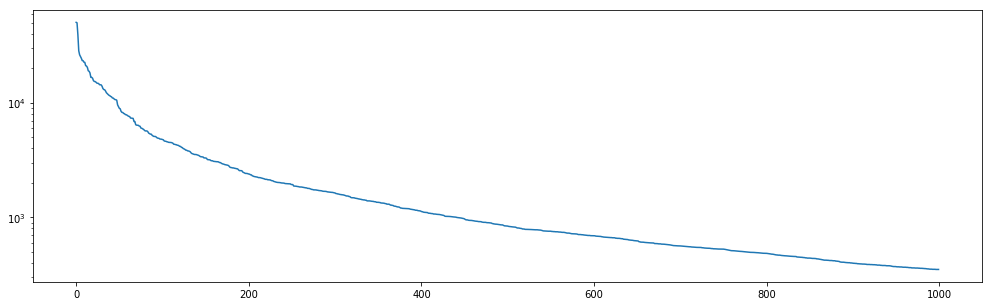

In [30]:
# Feature selection.
# Other options include: mutual information or document count.
freq = train.keep_top_words(1000, 20)
train.data_info()
train.show_document(1)
plt.figure(figsize=(17,5))
plt.semilogy(freq);

# Remove documents whose signal would be the zero vector.
wc = train.remove_short_documents(nwords=5, vocab='selected')
train.data_info(True)

In [31]:
train.normalize(norm='l1')
train.show_document(1);

document 1: label 6 --> 6, 61 words
  0.03 "beer" (0)
  0.03 "taste" (3)
  0.09 "malt" (7)
  0.03 "dark" (8)
  0.12 "light" (11)
  0.03 "smell" (20)
  0.03 "color" (30)
  0.03 "really" (32)
  0.06 "caramel" (33)
  0.03 "body" (34)
  0.03 "bitterness" (39)
  0.03 "fruit" (71)
  0.03 "drinkable" (76)
  0.06 "red" (111)
  0.03 "aftertaste" (112)
  0.03 "end" (117)
  0.06 "bad" (129)
  0.03 "maybe" (134)
  0.03 "foam" (156)
  0.06 "average" (199)
  0.03 "honey" (208)
  0.03 "note" (229)
  0.03 "fruitiness" (408)
  0.03 "beige" (505)
  0.03 "exceptional" (677)


In [33]:
# Test dataset.
#test = utils.Text20News(data_home=FLAGS.dir_data, subset='test', remove=remove)

test = utils.TextBeers(test=True)

test.clean_text(num='substitute')
test.vectorize(vocabulary=train.vocab)
test.data_info()
wc = test.remove_short_documents(nwords=5, vocab='selected')
print('shortest: {}, longest: {} words'.format(wc.min(), wc.max()))
test.data_info(True)
test.normalize(norm='l1')

10 10
N = 10000 documents, C = 10 classes
N = 10000 documents, M = 1000 words, sparsity=4.0963%
shortest: 0, longest: 300 words
N = 9993 documents, M = 1000 words, sparsity=4.0990%
      0 documents in class  0 (0)
      0 documents in class  1 (1)
     65 documents in class  2 (2)
     65 documents in class  3 (3)
    200 documents in class  4 (4)
    340 documents in class  5 (5)
    911 documents in class  6 (6)
   2007 documents in class  7 (7)
   3864 documents in class  8 (8)
   2011 documents in class  9 (9)


In [36]:
if True:
    train_data = train.data.astype(np.float32)
    test_data = test.data.astype(np.float32)
    train_labels = train.labels
    test_labels = test.labels
else:
    perm = np.random.RandomState(seed=42).permutation(dataset.data.shape[0])
    Ntest = 6695
    perm_test = perm[:Ntest]
    perm_train = perm[Ntest:]
    train_data = train.data[perm_train,:].astype(np.float32)
    test_data = train.data[perm_test,:].astype(np.float32)
    train_labels = train.labels[perm_train]
    test_labels = train.labels[perm_test]

if True:
    graph_data = train.embeddings.astype(np.float32)
else:
    graph_data = train.data.T.astype(np.float32).toarray()

#del train, test

# Feature graph

In [37]:
t_start = time.process_time()
dist, idx = graph.distance_sklearn_metrics(graph_data, k=FLAGS.number_edges, metric=FLAGS.metric)
A = graph.adjacency(dist, idx)
print("{} > {} edges".format(A.nnz//2, FLAGS.number_edges*graph_data.shape[0]//2))
A = graph.replace_random_edges(A, 0)
graphs, perm = coarsening.coarsen(A, levels=FLAGS.coarsening_levels, self_connections=False)
L = [graph.laplacian(A, normalized=True) for A in graphs]
print('Execution time: {:.2f}s'.format(time.process_time() - t_start))
#graph.plot_spectrum(L)
#del graph_data, A, dist, idx

KeyboardInterrupt: 

In [38]:
t_start = time.process_time()
dist, idx = graph.distance_lshforest(graph_data.astype(np.float64), k=FLAGS.number_edges, metric=FLAGS.metric)
A = graph.adjacency(dist.astype(np.float32), idx)
print("{} > {} edges".format(A.nnz//2, FLAGS.number_edges*graph_data.shape[0]//2))
A = graph.replace_random_edges(A, 0)
graphs, perm = coarsening.coarsen(A, levels=FLAGS.coarsening_levels, self_connections=False)
L = [graph.laplacian(A, normalized=True) for A in graphs]
print('Execution time: {:.2f}s'.format(time.process_time() - t_start))
#graph.plot_spectrum(L)
#del graph_data, A, dist, idx

11266 > 8000 edges
Layer 0: M_0 = |V| = 1000 nodes (0 added),|E| = 11266 edges
Execution time: 2.52s


In [39]:
t_start = time.process_time()
train_data = scipy.sparse.csr_matrix(coarsening.perm_data(train_data.toarray(), perm))
test_data = scipy.sparse.csr_matrix(coarsening.perm_data(test_data.toarray(), perm))
print('Execution time: {:.2f}s'.format(time.process_time() - t_start))
del perm

Execution time: 0.73s


# Classification

**Reminder**: change the optimizer to Adam in `lib/models.py`.

In [40]:
# Training set is shuffled already.
#perm = np.random.permutation(train_data.shape[0])
#train_data = train_data[perm,:]
#train_labels = train_labels[perm]

# Validation set.
if False:
    val_data = train_data[:FLAGS.val_size,:]
    val_labels = train_labels[:FLAGS.val_size]
    train_data = train_data[FLAGS.val_size:,:]
    train_labels = train_labels[FLAGS.val_size:]
else:
    val_data = test_data
    val_labels = test_labels

In [41]:
if True:
    utils.baseline(train_data, train_labels, test_data, test_labels)

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Train accuracy:      46.70 39.69 36.56 98.78 36.54 42.35 43.57
Test accuracy:       31.75 39.11 28.20 34.77 38.67 40.54 40.57
Train F1 (weighted): 43.97 28.72 36.85 98.78 19.55 34.64 37.01
Test F1 (weighted):  28.60 24.69 29.19 30.83 21.56 31.15 32.78
Execution time:      225.96  5.11  0.14 22.44  0.10  6.44  5.56


In [42]:
common = {}
common['dir_name']       = 'beer/'
common['num_epochs']     = 80
common['batch_size']     = 100
common['decay_steps']    = len(train_labels) / common['batch_size']
common['eval_frequency'] = 5 * common['num_epochs']
common['filter']         = 'chebyshev5'
common['brelu']          = 'b1relu'
common['pool']           = 'mpool1'
C = max(train_labels) + 1  # number of classes

model_perf = utils.model_perf()

In [ ]:
if True:
    name = 'softmax'
    params = common.copy()
    params['dir_name'] += name
    params['regularization'] = 0
    params['dropout']        = 1
    params['learning_rate']  = 1e3
    params['decay_rate']     = 0.95
    params['momentum']       = 0.9
    params['F']              = []
    params['K']              = []
    params['p']              = []
    params['M']              = [C]
    model_perf.test(models.cgcnn(L, **params), name, params,
                    train_data, train_labels, val_data, val_labels, test_data, test_labels)

In [ ]:
if True:
    name = 'fc_softmax'
    params = common.copy()
    params['dir_name'] += name
    params['regularization'] = 0
    params['dropout']        = 1
    params['learning_rate']  = 0.1
    params['decay_rate']     = 0.95
    params['momentum']       = 0.9
    params['F']              = []
    params['K']              = []
    params['p']              = []
    params['M']              = [2500, C]
    model_perf.test(models.cgcnn(L, **params), name, params,
                    train_data, train_labels, val_data, val_labels, test_data, test_labels)

In [ ]:
if True:
    name = 'fc_fc_softmax'
    params = common.copy()
    params['dir_name'] += name
    params['regularization'] = 0
    params['dropout']        = 1
    params['learning_rate']  = 0.1
    params['decay_rate']     = 0.95
    params['momentum']       = 0.9
    params['F']              = []
    params['K']              = []
    params['p']              = []
    params['M']              = [2500, 500, C]
    model_perf.test(models.cgcnn(L, **params), name, params,
                    train_data, train_labels, val_data, val_labels, test_data, test_labels)

In [ ]:
if True:
    name = 'fgconv_softmax'
    params = common.copy()
    params['dir_name'] += name
    params['filter']         = 'fourier'
    params['regularization'] = 0
    params['dropout']        = 1
    params['learning_rate']  = 0.001
    params['decay_rate']     = 1
    params['momentum']       = 0
    params['F']              = [32]
    params['K']              = [L[0].shape[0]]
    params['p']              = [1]
    params['M']              = [C]
    model_perf.test(models.cgcnn(L, **params), name, params,
                    train_data, train_labels, val_data, val_labels, test_data, test_labels)

In [ ]:
if True:
    name = 'sgconv_softmax'
    params = common.copy()
    params['dir_name'] += name
    params['filter']         = 'spline'
    params['regularization'] = 1e-3
    params['dropout']        = 1
    params['learning_rate']  = 0.1
    params['decay_rate']     = 0.999
    params['momentum']       = 0
    params['F']              = [32]
    params['K']              = [5]
    params['p']              = [1]
    params['M']              = [C]
    model_perf.test(models.cgcnn(L, **params), name, params,
                    train_data, train_labels, val_data, val_labels, test_data, test_labels)

In [ ]:
if True:
    name = 'cgconv_softmax'
    params = common.copy()
    params['dir_name'] += name
    params['regularization'] = 1e-3
    params['dropout']        = 1
    params['learning_rate']  = 0.1
    params['decay_rate']     = 0.999
    params['momentum']       = 0
    params['F']              = [32]
    params['K']              = [5]
    params['p']              = [1]
    params['M']              = [C]
    model_perf.test(models.cgcnn(L, **params), name, params,
                    train_data, train_labels, val_data, val_labels, test_data, test_labels)

In [43]:
if True:
    name = 'cgconv_fc_softmax'
    params = common.copy()
    params['dir_name'] += name
    params['regularization'] = 0
    params['dropout']        = 1
    params['learning_rate']  = 0.1
    params['decay_rate']     = 0.999
    params['momentum']       = 0
    params['F']              = [5]
    params['K']              = [15]
    params['p']              = [1]
    params['M']              = [100, C]
    model_perf.test(models.cgcnn(L, **params), name, params,
                    train_data, train_labels, val_data, val_labels, test_data, test_labels)

NN architecture
  input: M_0 = 1000
  layer 1: cgconv1
    representation: M_0 * F_1 / p_1 = 1000 * 5 / 1 = 5000
    weights: F_0 * F_1 * K_1 = 1 * 5 * 15 = 75
    biases: F_1 = 5
  layer 2: fc1
    representation: M_2 = 100
    weights: M_1 * M_2 = 5000 * 100 = 500000
    biases: M_2 = 100
  layer 3: logits (softmax)
    representation: M_3 = 11
    weights: M_2 * M_3 = 100 * 11 = 1100
    biases: M_3 = 11
step 400 / 31982 (epoch 1.00 / 80):
  learning_rate = 1.00e-01, loss_average = 1.68e+00


/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


  validation accuracy: 38.67 (3864 / 9993), f1 (weighted): 21.56, loss: 1.67e+00
  time: 139s (wall 44s)
step 800 / 31982 (epoch 2.00 / 80):
  learning_rate = 9.99e-02, loss_average = 1.70e+00
  validation accuracy: 38.67 (3864 / 9993), f1 (weighted): 21.56, loss: 1.68e+00
  time: 274s (wall 85s)
step 1200 / 31982 (epoch 3.00 / 80):
  learning_rate = 9.98e-02, loss_average = 1.66e+00
  validation accuracy: 38.67 (3864 / 9993), f1 (weighted): 21.56, loss: 1.67e+00
  time: 409s (wall 126s)
step 1600 / 31982 (epoch 4.00 / 80):
  learning_rate = 9.97e-02, loss_average = 1.65e+00
  validation accuracy: 38.67 (3864 / 9993), f1 (weighted): 21.56, loss: 1.66e+00
  time: 550s (wall 170s)
step 2000 / 31982 (epoch 5.00 / 80):
  learning_rate = 9.95e-02, loss_average = 1.68e+00
  validation accuracy: 38.67 (3864 / 9993), f1 (weighted): 21.56, loss: 1.67e+00
  time: 694s (wall 215s)
step 2400 / 31982 (epoch 6.00 / 80):
  learning_rate = 9.94e-02, loss_average = 1.66e+00
  validation accuracy: 38.67

step 17200 / 31982 (epoch 43.02 / 80):
  learning_rate = 9.58e-02, loss_average = 1.67e+00
  validation accuracy: 38.67 (3864 / 9993), f1 (weighted): 21.56, loss: 1.66e+00
  time: 5124s (wall 1300s)
step 17600 / 31982 (epoch 44.02 / 80):
  learning_rate = 9.57e-02, loss_average = 1.67e+00
  validation accuracy: 38.67 (3864 / 9993), f1 (weighted): 21.56, loss: 1.66e+00
  time: 5243s (wall 1327s)
step 18000 / 31982 (epoch 45.02 / 80):
  learning_rate = 9.56e-02, loss_average = 1.66e+00
  validation accuracy: 38.67 (3864 / 9993), f1 (weighted): 21.56, loss: 1.67e+00
  time: 5360s (wall 1354s)
step 18400 / 31982 (epoch 46.03 / 80):
  learning_rate = 9.55e-02, loss_average = 1.67e+00
  validation accuracy: 38.67 (3864 / 9993), f1 (weighted): 21.56, loss: 1.67e+00
  time: 5476s (wall 1382s)
step 18800 / 31982 (epoch 47.03 / 80):
  learning_rate = 9.54e-02, loss_average = 1.71e+00
  validation accuracy: 38.67 (3864 / 9993), f1 (weighted): 21.56, loss: 1.66e+00
  time: 5590s (wall 1409s)
step 

  accuracy        F1             loss        time [ms]  name
test  train   test  train   test     train
38.67 36.54   21.56 19.55   1.66e+00 1.67e+00    74   cgconv_fc_softmax


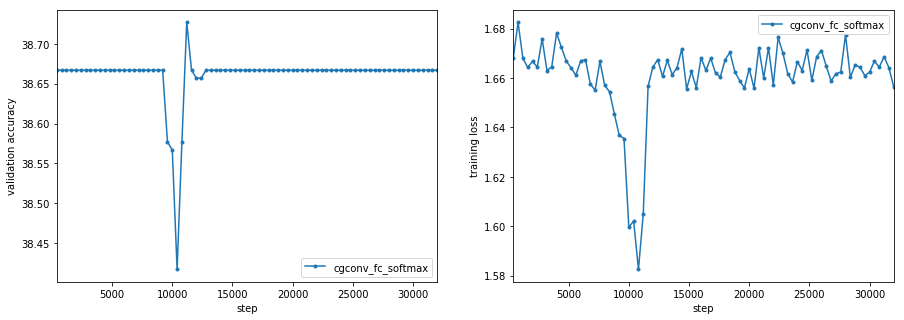

In [44]:
model_perf.show()

In [45]:
if False:
    grid_params = {}
    data = (train_data, train_labels, val_data, val_labels, test_data, test_labels)
    utils.grid_search(params, grid_params, *data, model=lambda x: models.cgcnn(L,**x))